In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import random
import time
import warnings

from utils import *

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["figure.dpi"] = 160

cmap = cm.get_cmap('viridis', 101)
viridis = np.ndarray((101, 4))
for i in range(0, 101):
    viridis[i] = cmap(i/100)
    
cmap = cm.get_cmap('magma', 101)
magma = np.ndarray((101, 4))
for i in range(0, 101):
    magma[i] = cmap(i/100)
    
cmap = cm.get_cmap('inferno', 101)
inferno = np.ndarray((101, 4))
for i in range(0, 101):
    inferno[i] = cmap(i/100)
    
cmap = cm.get_cmap('prism', 101)
prism = np.ndarray((101, 4))
for i in range(0, 101):
    prism[i] = cmap(i/100)
    
cmap = cm.get_cmap('flag', 101)
flag = np.ndarray((101, 4))
for i in range(0, 101):
    flag[i] = cmap(i/100)
    
cmap = cm.get_cmap('ocean', 101)
ocean = np.ndarray((101, 4))
for i in range(0, 101):
    ocean[i] = cmap(i/100)
    
cmap = cm.get_cmap('tab10', 10)
tab10 = np.ndarray((10, 4))
for i in range(0, 10):
    tab10[i] = cmap(i/10)
    
cmap = cm.get_cmap('Set1', 9)
set1 = np.ndarray((9, 4))
for i in range(0, 9):
    set1[i] = cmap(i/9)

In [2]:
from PIL import Image

def saveImage(grid):
    palette = [0, 0, 0,
               77, 175, 74,
               228, 26, 28,
               55, 126, 184,
               152, 78, 163, 
               255, 127, 0, 
               255, 255, 51]
    palette = palette + [0]*(768-len(palette))
    pi = Image.fromarray(grid, 'P')
    pi.putpalette(palette)
    pi.save()

# show grid as palette PNG in default image viewer
# if 'flip' then the grid will be flipped vertically to account for image coordinates
def showImage(grid, flip=True):
    if flip:
        grid = np.flip(surface.pointgrid[:,:,0], axis=0).astype(np.uint8)
    palette = [0, 0, 0,
               77, 175, 74,
               228, 26, 28,
               55, 126, 184,
               152, 78, 163, 
               255, 127, 0, 
               255, 255, 51]
    palette = palette + [0]*(768-len(palette))
    pi = Image.fromarray(grid, 'P')
    pi.putpalette(palette)
    pi.show()
    
import copy

# show grid as palette PNG in default image viewer
# if 'flip' then the grid will be flipped vertically to account for image coordinates
def saveGrid2D(grid, deposited, params, system, subfolder='', flip=True, zipped=False):
    if flip:
        grid = np.flip(surface.pointgrid[:,:,0], axis=0).astype(np.uint8)
    filename = 'structures/2D/'
    if subfolder != '':
        filename += subfolder + '/'
    para = copy.deepcopy(params)
    for p in para:
        if isinstance(p['weights'], np.ndarray):
            p['weights'] = p['weights'].tolist()
    p = para[-1]
    dep = sum(deposited)
    time_now = int(round(time.time()))
    filename += 'SCTF_{}_L{}_Th{}_D{}_N{}_{}'.format(system, p['L'], p['theta'], p['D'], dep, time_now)
    json_data = {"Layers": len(para), "Total points": dep}
    palette = [0, 0, 0,
               77, 175, 74,
               228, 26, 28,
               55, 126, 184,
               152, 78, 163, 
               255, 127, 0, 
               255, 255, 51]
    palette = palette + [0]*(768-len(palette))
    pi = Image.fromarray(grid, 'P')
    pi.putpalette(palette)
    pi.save(filename + ".png")
    for i in range(1, len(para)+1):
        json_data[i] = {"Deposited": deposited[i-1], "Parameters": para[i-1]}
    with open(filename + ".json", 'w') as f:
        json.dump(json_data, f)
    if zipped:
        with gzip.GzipFile(filename + ".npy.gz", 'w+') as f:
            return np.save(f, grid)
    else:
        with open(filename + '.npy', 'wb') as f:
            return np.save(f, grid)
        


In [3]:
import Cython
%load_ext Cython

In [52]:
%%cython
cimport cython
import numpy as np
cimport numpy as np




@cython.boundscheck(False)
@cython.wraparound(False)
def calculateLocalEnergy(center, np.int8_t[:,:,:] grid, int species, float[:,:] weights, extra_memory):
    cdef Py_ssize_t x = center[0]
    cdef Py_ssize_t y = center[1]
    cdef Py_ssize_t x_max = grid.shape[1]
    cdef Py_ssize_t y_max = grid.shape[0]
    cdef np.int8_t[:,:,:] grid_view = grid
    cdef float[:,:] weights_view = weights
    
    #if extra_memory == True:
    #    return e_view[y,x, species-1]
    
    energy = 0
    cdef Py_ssize_t i, ii, j, jj
    for i in [-1, 0, 1]:
        ii = (x + i) % x_max
        for j in [-1, 0, 1]:
            jj = y + j
            # only compute with neighbors within bounds
            if (i == 0 and j == 0) or jj < 0 or jj > y_max-1:
                continue
            if i == 0 or j == 0:
                # shares side
                energy += weights_view[int(species), grid_view[jj,ii,0]]
            elif i != 0 and j != 0:
                # shares corner
                energy += weights_view[int(species), grid_view[jj,ii,0]]/1.414
    return energy

@cython.boundscheck(False)
@cython.wraparound(False)
def updateLocalEnergy(center, np.int8_t[:,:,:] grid, int species, int max_species, float[:,:] weights, extra_memory):
    cdef Py_ssize_t x = center[0]
    cdef Py_ssize_t y = center[1]
    cdef Py_ssize_t x_max = grid.shape[1]
    cdef Py_ssize_t y_max = grid.shape[0]
    cdef np.int8_t[:,:,:] grid_view = grid
    cdef float[:,:] weights_view = weights
    
    cdef Py_ssize_t i, ii, j, jj
    for i in [-1, 0, 1]:
        ii = (x + i) % x_max
        for j in [-1, 0, 1]:
            jj = y + j
            # only compute with neighbors within bounds
            if (i == 0 and j == 0) or jj < 0 or jj > y_max-1:
                continue
            for s in range(1, max_species+1):
                # need to include distance modifier
                pass
                #e_view[jj,ii,species-1] += weights_view[grid_view[jj,ii,0], int(s)]
    return


@cython.boundscheck(False)
@cython.wraparound(False)
def getAdjacentVacancies(center, np.int8_t[:,:,:] grid, int species, float[:,:] weights, extra_memory):
    cdef Py_ssize_t x = center[0]
    cdef Py_ssize_t y = center[1]
    cdef Py_ssize_t x_max = grid.shape[1]
    cdef Py_ssize_t y_max = grid.shape[0]
    cdef np.int8_t[:,:,:] grid_view = grid
    
    vacancy_list = []
    weight_list = []
    cdef Py_ssize_t i, ii, j, jj
    for i in [-1, 0, 1]:
        ii = (x + i) % x_max
        for j in [-1, 0, 1]:
            jj = y + j
            if jj < 0 or jj > y_max-1:
                continue
            if grid_view[jj,ii,0] == 0 and (grid_view[jj,ii,1] > 0 or jj == 0):
                if len(weights) > 0:
                    weight_list.append(calculateLocalEnergy((ii,jj), grid, species, weights, extra_memory))
                vacancy_list.append((ii,jj))
    return vacancy_list, weight_list

@cython.boundscheck(False)
@cython.wraparound(False)
def traversePath(float[:,:] path, np.int8_t[:,:] grid, float[:] dest, log, str log_content):
    cdef np.int8_t[:,:] grid_view = grid
    cdef float[:,:] points = path
    cdef float[:] off = dest
    cdef Py_ssize_t height = grid.shape[0]
    cdef Py_ssize_t L = grid.shape[1]
    cdef i
    
    for i in range(0, len(path)):
        if grid_view[int(points[i,1]), int(round((points[i,0]+off[0]) % L))] > 0:
            # intersection before reaching end destination
            if points[i-1,1] < height:
                collision = (int(points[i-1,1]), int(round((points[i-1,0]+off[0]) % L)))
            else:
                print("Hitting maximum box height; returning early.")
                return None
            break
        elif int(round((points[i,0]+off[0]) % L)) == int(round(off[0])) and int(round(points[i,1])) == int(round(off[1])):
            if off[1] < height:
                collision = (int(off[1]), int(round(off[0])))
            else:
                print("Hitting maximum box height; returning early.")
                return None
            break
    return collision


@cython.boundscheck(False)
@cython.wraparound(False)
def traversePathVariable(float[:,:] path, np.int8_t[:,:] grid, float[:] dest, log, str log_content):
    cdef np.int8_t[:,:] grid_view = grid
    cdef float[:,:] points = path
    cdef float[:] dest_view = dest
    cdef Py_ssize_t height = grid.shape[0]
    cdef Py_ssize_t L = grid.shape[1]
    cdef i
    
    for i in range(0, len(path)):
        if grid_view[int(points[i,1]), int(round(points[i,0] % L))] > 0:
            # intersection before reaching end destination
            if points[i-1,1] < height:
                collision = (int(points[i-1,1]), int(round(points[i-1,0] % L)))
            else:
                print("Hitting maximum box height; returning early.")
                return None
            break
        elif int(round(points[i,0] % L)) == int(round(dest_view[0])) and int(round(points[i,1])) == int(round(dest_view[1])):
            if dest_view[1] < height:
                collision = (int(dest_view[1]), int(round(dest_view[0])))
            else:
                print("Hitting maximum box height; returning early.")
                return None
            break
    return collision

@cython.boundscheck(False)
@cython.wraparound(False)
def traversePathRealTime(float[:] source, float[:] destination, np.int8_t[:,:] grid):
    cdef np.int8_t[:,:] grid_view = grid
    cdef float[:] src = source
    cdef float[:] dest = destination
    cdef Py_ssize_t height = grid.shape[0]
    cdef Py_ssize_t L = grid.shape[1]
    
    dx = abs(dest[0] - src[0])
    dy = abs(dest[1] - src[1])
    if (dest[0] > src[0]):
        xs = 1
    else:
        xs = -1
    if (dest[1] > src[1]):
        ys = 1
    else:
        ys = -1

    x1 = src[0]
    y1 = src[1]
    x2 = dest[0]
    y2 = dest[1]
    
    # Driving axis is X-axis"
    if (dx >= dy):  
        p1 = 2 * dy - dx
        while (x1 != x2):
            if grid_view[int(y1), int(round(x1 % L))] > 0:
                return (int(y1 - ys), int((x1 - xs) % L))
            x1 += xs
            if (p1 >= 0):
                y1 += ys
                p1 -= 2 * dx
            p1 += 2 * dy
        return (int(y1 - ys), int((x1 - xs) % L))
    # Driving axis is Y-axis"
    elif (dy >= dx):
        p1 = 2 * dx - dy
        while (y1 != y2):
            if grid_view[int(y1), int(round(x1 % L))] > 0:
                return (int(y1 - ys), int((x1 - xs) % L))
            y1 += ys
            if (p1 >= 0):
                x1 += xs
                p1 -= 2 * dy
            p1 += 2 * dx
        return (int(y1 - ys), int((x1 - xs) % L))

# we can assume that dx >> dy, so the driving axis is X-axis
# dest is on the surface so ys < 0
'''def Bresenham2D(src, dest):
    dx = dest[0] - src[0]
    dy = dest[1] - src[1]
    x1 = src[0]
    y1 = src[1]
    pointlist = [None] * int(dy+abs(dx))
    
    if dest[0] > src[0]:
        xs = 1
        p1 = 2 * dy - dx
        while (x1 > dest[0]):
            x1 += 1
            if (p1 >= 0):
                y1 -= 1
                p1 -= 2*dx
            p1 += 2 * dy
            try:
                pointlist[i] = np.array([x1, y1])
                
    else:
        xs = -1
    '''
    
    

In [54]:
#class Point:
#    def __init__(self, x, y, *args, **kwargs):
#        super().__init__(*args, **kwargs)
#        self.x = int(x)
#        self.y = int(y)
#        
#    def __repr__(self):
#        return "Point({}, {})".format(self.x, self.y)
#    
#    def __str__(self):
#        return "({}, {})".format(self.x, self.y)
        
''' Holds all surface points for quick access ''' 
class Surface:
    def __init__(self, length, height, species=1, weights=[], cython=True, extra_memory=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._L = length
        self._h = height
        #self.pointlist = list()
        self.pointgrid = np.zeros((self._h, self._L, 2)).astype(np.int8) # (y, x, species/nearest neighbors)
        #self.pointgrid[:,:,0] = -1
        self.weights = weights
        self.cython = cython
        self._extra_memory = extra_memory
        if self._extra_memory:
            self.energy = {}
            if isinstance(species, list):
                for s in species:
                    if s not in self.energy.keys():
                        self.energy[s] = np.zeros((self._h, self._L))
            else:
                self.energy[species] = np.zeros((self._h, self._L))
        
    def add(self, point, species=1):
        # add point
        #self.pointlist.append((point[0], point[1]))
        #self.pointgrid[point[1], point[0], 0] = len(self.pointlist)-1
        self.pointgrid[point[1], point[0], 0] = species
        
        # update nearest neighbors
        self.pointgrid[point[1], (point[0]-1)%self._L, 1] += 1
        self.pointgrid[point[1], (point[0]+1)%self._L, 1] += 1
        if point[1] > 0:
            self.pointgrid[point[1]-1, (point[0]-1)%self._L, 1] += 1
            self.pointgrid[point[1]-1, point[0], 1] += 1
            self.pointgrid[point[1]-1, (point[0]+1)%self._L, 1] += 1
        if point[1] < self._h - 1:
            self.pointgrid[point[1]+1, (point[0]-1)%self._L, 1] += 1
            self.pointgrid[point[1]+1, point[0], 1] += 1
            self.pointgrid[point[1]+1, (point[0]+1)%self._L, 1] += 1
            
        # if applicable, update energy maps
        if self._extra_memory:
            for i in [-1, 0, 1]:
                ii = (point[0] + i) % self._L
                for j in [-1, 0, 1]:
                    jj = point[1] + j
                    if jj < 0 or jj > self._h - 1:
                        continue
                    for s in self.energy.keys():
                        if i == 0 or j == 0:
                            # shares side
                            self.energy[s][point[1], point[0]] += self.weights[int(species), s]
                        elif i != 0 and j != 0:
                            # shares corner
                            self.energy[s][point[1], point[0]] += self.weights[int(species), s]/1.414
        
    def remove(self, point):
        # get index, remove from list, and set grid point to no index
        #index = self.pointgrid[point[1], point[0], 0]
        #self.pointlist.pop(index)
        #self.pointgrid[point[1], point[0], 0] = -1
        self.pointgrid[point[1], point[0], 0] = 0
        
        # update nearest neighbors
        self.pointgrid[point[1], (point[0]-1)%self._L, 1] -= 1
        self.pointgrid[point[1], (point[0]+1)%self._L, 1] -= 1
        if point[1] > 0:
            self.pointgrid[point[1]-1, (point[0]-1)%self._L, 1] -= 1
            self.pointgrid[point[1]-1, point[0], 1] -= 1
            self.pointgrid[point[1]-1, (point[0]+1)%self._L, 1] -= 1
        if point[1] < self._h - 1:
            self.pointgrid[point[1]+1, (point[0]-1)%self._L, 1] -= 1
            self.pointgrid[point[1]+1, point[0], 1] -= 1
            self.pointgrid[point[1]+1, (point[0]+1)%self._L, 1] -= 1
        
        # update grid indices
        #for i in range(index, len(pointlist)-1):
        #    self.pointgrid[self.pointlist[i][1], self.pointlist[i][0]] = i
            
        # if applicable, update energy maps
        if self._extra_memory:
            for i in [-1, 0, 1]:
                ii = (point[0] + i) % self._L
                for j in [-1, 0, 1]:
                    jj = point[1] + j
                    if jj < 0 or jj > self._h - 1:
                        continue
                    for s in self.energy.keys():
                        if i == 0 or j == 0:
                            # shares side
                            self.energy[s][point[1], point[0]] -= self.weights[int(species), s]
                        elif i != 0 and j != 0:
                            # shares corner
                            self.energy[s][point[1], point[0]] -= self.weights[int(species), s]/1.414
            
            
    def getAdjacentVacancy(self, center, species=1, weights=[], deterministic=False):
        vacancy_list = []
        weight_list = []
        if self.cython:
            vacancy_list, weight_list = getAdjacentVacancies(center, self.pointgrid, species, weights, self._extra_memory)
            if len(vacancy_list) == 0:
                return None
            if len(weights) > 0:
                if deterministic:
                    return(vacancy_list[np.argmax(weight_list)])
                mi = np.amin(weight_list)
                ma = np.amax(weight_list)
                if ma < 0:
                    for w in weight_list:
                        w -= mi
                else:
                    if mi < 0:
                        for w in weight_list:
                            if w < 0:
                                w = 0
                return random.choices(vacancy_list, weights=weight_list)[0]
            return vacancy_list[random.randint(0, len(vacancy_list)-1)]
        for i in [-1, 0, 1]:
            try:
                ii = (center[0] + i) % self._L
            except TypeError:
                print(i,center)
                raise TypeError()
            for j in [-1, 0, 1]:
                jj = center[1] + j
                #print(ii,jj)
                if jj < 0:
                    continue
                if jj > self._h-1:
                    continue
                if self.pointgrid[jj,ii,0] == 0 and (self.pointgrid[jj,ii,1] > 0 or jj == self._h-1):
                    if len(self.weights) > 0:
                        if self._extra_memory:
                            weight_list.append(self.energy[species][jj,ii])
                        else:
                            weight_list.append(self.calculateLocalEnergy((ii,jj), species, weights=self.weights))
                    vacancy_list.append((ii,jj))
        if len(vacancy_list) == 0:
            return None
        try:
            if len(self.weights) > 0:
                return random.choices(vacancy_list, weights=weight_list)[0]
            return vacancy_list[random.randint(0, len(vacancy_list)-1)]
        except ValueError:
            print("Surface atoms:\n{}".format(self.pointgrid[center[1]-1:center[1]+2,center[0]-1:center[0]+2,0]))
            print("Nearest neighbors:\n{}".format(self.pointgrid[center[1]-1:center[1]+2,center[0]-1:center[0]+2,1]))
            return None
        
    def calculateLocalEnergy(self, center, species, weights):
        if self.cython:
            return calculateLocalEnergy(center, self.pointgrid, species, weights, self._extra_memory)
        energy = 0
        for i in [-1, 0, 1]:
            ii = (center[0] + i) % self._L
            for j in [-1, 0, 1]:
                jj = center[1] + j
                if i == 0 and j == 0:
                    pass
                #print(ii,jj,kk)
                if jj < 0:
                    continue
                if jj > self._h-1:
                    continue
                try:
                    if i == 0 or j == 0:
                        # shares side
                        energy += weights[int(species), self.pointgrid[jj,ii,0]]
                    elif i != 0 and j != 0:
                        # shares corner
                        energy += weights[int(species), self.pointgrid[jj,ii,0]]/1.414
                    else:
                        print("Center {} and \"adjacent\" vertex {} are not adjacent.".format(center, (ii,jj)))
                except IndexError:
                    print("There is no weight for pair {}.".format((int(species), self.pointgrid[jj,ii,0])))
        return energy
            
    def is_surface(self, point):
        if self.pointgrid[point[1], point[0], 0] > 0:
            return True
        else:
            return False
        
    #def random_point(self):
    #    return self.pointlist[random.randint(0, len(self.pointlist) - 1)]
    
    
def surfaceFromGrid(grid, L, H):
    surfaceAtoms = Surface(L, H)
    for i in range(L):
            for j in range(0, H):
                if grid[j,i] > 0:
                    surfaceAtoms.add((i,j), species=grid[j,i])
    return surfaceAtoms

In [55]:
''' 1D simulation '''
def obliqueDeposition2D(theta=75, L=64, height=128, reps=8192, D=0, species=1, inputSurface=None, inputGrid=None, weights=[], spread=0, extra_memory=False, deterministic=False, log=False):
    weights = weights.astype(np.float32)
    maxh=height-1
    grid = np.zeros((height, L)).astype(np.int8) # store particle state of each position
    if isinstance(inputGrid, np.ndarray):
        if grid.shape[1] != inputGrid.shape[1] or grid.shape[0] < inputGrid.shape[0]:
            raise ValueError("Shape of grid {} and input grid {} do not match.".format(grid.shape, inputGrid.shape))
        else:
            grid[height-inputGrid.shape[0]:, :] = inputGrid
    
    nn_dist = 3
    if log:
        log_content = "Deposition in {}x{} box with {} repetitions\n".format(L, height, reps)
        log_content += "Deposition from {} deg\n".format(theta)
        if D > 0:
            log_content += "{} diffusion steps chosen within {} of collision point\n".format(D, nn_dist)
    else:
        log_content = None
    
    params = {'L': L, 'theta': theta, 'H': height, 'D': D, 'species': species, 'weights': weights, 'repetition': reps, 'spread': spread, 'time': 0}

    deposited = 0
    
    # create surface
    paths = {}
    if not isinstance(inputGrid, np.ndarray):
        surface = Surface(length=L, height=height, species=species, weights=weights, extra_memory=extra_memory)
    else:
        surface = surfaceFromGrid(inputGrid, L, height)
    
    grid = surface.pointgrid[:,:,0]
    
    if spread != 0:
        mu, sigma = 0, spread # mean and standard deviation
        distribution = np.random.default_rng().normal(mu, sigma, reps)
        #distribution = np.random.default_rng().triangular(-2, 0, 2, reps)
        #distribution = np.random.default_rng().uniform(-2, 2, reps)
        #distribution = 2*np.random.default_rng().beta(0.75, 0.75, reps)
        offset = np.array([0, 0], dtype=np.float32)
    else:
        src = (int(round((height-1)/tand(-90+theta))), height-1)
        dest = (0,0,0)
        points = getLinePointsP(src,dest)
        path = np.zeros((len(points), 2), dtype=np.float32)
        print("Calculated path length: {}.".format(path.shape))
        for i in range(0, len(points)):
            path[i, :] = points[i]
        dtheta = 0
    
    diffusion_lengths = np.zeros((reps))
    update = max((int(reps / 128), 1))
    start = time.time()
    endl = 0
    endd = 0
    for n in range(0, reps):
        # choose a random target point
        startl = time.time()
        dest = np.array([random.randint(0,L-1), 0], dtype=np.float32)
        if spread != 0:
            dtheta = distribution[n]
            if dtheta + theta >= 90.0:
                continue
            src = (int(round((height-1)/tand(-90+theta+dtheta))), height-1)
            collision = traversePathRealTime(src, dest, grid)
        else:
            collision = traversePath(path, grid, dest, log, log_content)

        # find line of sight
        
        #if dest[0] not in paths.keys():
            
        #    points = getLinePointsP(src, dest)
        #    paths[dest[0]] = points
        #else:
        #    points = paths[dest[0]]
        #print("Particle {} targeting {} from {}.".format(n+1, dest, src))

        # find where it stops
        #for i in range(0, len(points)):
        #    if points[i][1] < 0:
        #        print(i)
        #        continue
        #    if points[i] is None:
        #        break

        #    if grid[points[i][1], points[i][0] % L] > 0:
                #print("Particle {} had early collision at {}.".format(n+1, collision))
        #        if points[i-1][1] < height:
        #            collision = (points[i-1][1], points[i-1][0] % L)
        #        break
        #    elif points[i][0] % L == dest[0] and points[i][1] == dest[1]:
                #print("Particle {} reached destination at {}.".format(n+1, collision))
        #        if dest[1] < height:
        #            collision = (dest[1], dest[0])
        #        break
        
        endl += time.time() - startl

        startd = time.time()
        diffusing = (collision[1], collision[0])
        if int(diffusing[0]) >= 1024:
            if dtheta != 0:
                print("D-theta: {}\nDestination: {}\nDiffusing: {}\nCollision: {}".format(dtheta, dest, diffusing, collision))
                for i in range(path.shape[0]):
                    print(path[i,:])
                    continue

        # choose species
        if isinstance(species, list):
            sp = random.choices(species)[0]
        else:
            sp = species

        # diffuse
        for d in range(0, D):
            # diffuse colliding atom
            vacancy = surface.getAdjacentVacancy(diffusing, species=sp, weights=weights, deterministic=deterministic)
            if vacancy == None:
                if log:
                    log_content += "\tNo more vacancies around {}.\n".format(diffusing)
                break
            if log:
                log_content += "\tDiffusing atom moved from {} to {} at step {}.\n".format(diffusing, vacancy, d+1)
            diffusing = vacancy
        if grid[diffusing[1], diffusing[0]] == 0:
            grid[diffusing[1], diffusing[0]] = sp
        else:
            if log:
                log_content += "IndexError: Grid location {} already populated.".format(diffusing)
            #raise IndexError("IndexError: Grid location {} already populated.".format(diffusing))
        if (diffusing[0] - collision[1]) > D:
            diffusion_lengths[n] = (diffusing[0] - collision[1] - L)**2 + (diffusing[1] - collision[0])**2
        elif diffusing[0] - collision[1] < -D:
            diffusion_lengths[n] = (diffusing[0] - collision[1] + L)**2 + (diffusing[1] - collision[0])**2
        else:
            diffusion_lengths[n] = (diffusing[0] - collision[1])**2 + (diffusing[1] - collision[0])**2
        surface.add(diffusing, sp)
        deposited += 1
        endd += time.time() - startd


        if n % update == update - 1:
            up_time = time.time() - start
            print("{}/{} complete; {:.3f} seconds taken; {:.3f} reps per second.".format(n+1, reps, up_time, deposited/up_time))
    end = time.time()
    params['time'] = end - start
    
    repp = "{} reps completed in {:.3f} seconds;\n{:.3f} reps per second.".format(reps, end - start, reps/(end-start))
    linep = "Line finding was {:.3f} seconds of that time.".format(endl)
    diffd = "Diffusion was {:.3f} seconds of that time.".format(endd)
    
    print(repp)
    print(linep)
    print(diffd)
    
    if log:
        log_content += repp + '\n' + linep + '\n' + diffd
    
    return grid, deposited, surface, log_content, params, diffusion_lengths

In [7]:
# load substrate for faster simulations
substrate, sdep, spar = loadGrid2D("SCTF_Si_L1024_Th85.5_D20_N65536_1655487930.npy")
sdep = sdep[0]
spar = spar[0]

In [61]:
#theta = 85.5 # angle of incidence
#L = 512+256 # length of simulation area
#D = 1 # diffusion steps
#reps = 8192*8 # number of particles to send at surface
#height = 256*2

Si = np.array([[1, 0], [0, 1]])
Si_Ag = np.array([[1, 0, 0], [0, 1, 0], [.2, -.3, 3]]) # 0/Si/Ag
Si_Au = np.array([[1, 0, 0], [0, 5, -2], [0, -15, 15]])
FeNi_Co_nakazawa = np.array([[1, 0, 0, 0], [0, 1, 3.1875, 1], [0, 3.1875, 1.25, 1], [0, 1, 1, 3]])
FeNi_Co_rao = np.array([[1, 0, 0, 0], [0, 1, 1.370588, 1], [0, 1.370588, 1.664706, 1], [0, 1, 1, 2]])
ZrO2 = np.array([[1, 0, 0], [0, 1, 5], [0, 5, 1]])

weights = Si_Au
'''system = "Si"
for t in [80, 85.5]:
    lengths = []
    for D in [1, 5, 10, 25, 50]:
        grid, deposited1, surface, log1, params1, l = obliqueDeposition2D(theta=t, L=1024, height=768, reps=65536//4, D=D, species=1, weights=weights, spread=0)
        l = l**0.5
        lengths.append(l)
        deposited = [deposited1]
        params = [params1]
        saveGrid2D(grid, deposited, params, system, subfolder='')
        print("{} {} done".format(t, D))
    for i in range(0, 5):
        print("Diffusion step {}".format((1, 5, 10, 25, 50)[i]))
        L_mean = np.mean(lengths[i])
        L_std = np.std(lengths[i])
        #print(lengths[i])
        print("Max: {:.3f}\tMin: {:.3f}".format(np.max(lengths[i]), np.min(lengths[i])))
        print("Mean: {:.3f}\STD: {:.3f}".format(np.mean(lengths[i]), np.std(lengths[i])))
    # convert lengths to nice for viewing csv
    lcsv = np.zeros((len(lengths[i])+1, 5))
    lcsv[0,:] = [1, 5, 10, 25, 50]
    for i in range(5):
        lcsv[1:,i] = np.array(lengths[i]).T
    np.savetxt('data/diffl{}.txt'.format(t), lcsv)'''

system = "Si_Au"
L = 1024
h = 512
reps = 8192*4
DSi = 50
grid = np.zeros((h,L))
for i in range(L):
    grid[0,i] = 1
deposited = []
params = []
grid, deposited1, surface, log1, params1, l1 = obliqueDeposition2D(theta=85.5, L=L, height=h, reps=reps, D=DSi, species=1, inputGrid=grid, weights=weights)
deposited.append(deposited1)
params.append(params1)
#saveGrid2D(grid, deposited, params, "Si")

grid, deposited2, surface, log2, params2, l2 = obliqueDeposition2D(theta=85.5, L=L, height=h, reps=reps//8, D=500, species=2, inputGrid=grid, weights=weights)
deposited.append(deposited2)
params.append(params2)
#saveGrid2D(grid, deposited, params, system)

grid, deposited3, surface, log3, params3, l3 = obliqueDeposition2D(theta=85.5, L=L, height=h, reps=reps, D=DSi, species=1, inputGrid=grid, weights=weights)
deposited.append(deposited3)
params.append(params3)
#saveGrid2D(grid, deposited, params, system)

grid, deposited4, surface, log4, params4, l4 = obliqueDeposition2D(theta=85.5, L=L, height=h, reps=reps//8, D=500, species=2, inputGrid=grid, weights=weights)
deposited.append(deposited4)
params.append(params4)
saveGrid2D(grid, deposited, params, system)

#system = "Si_Ag"

#for r in [65536]:
#    for D in [0, 1, 5, 10, 25, 50]:
#        grid, deposited1, surface, log1, params1 = obliqueDeposition2D(theta=85.5, L=1024, height=512, reps=8192*2, D=1, species=[1], weights=weights, spread=.704, deterministic=True)
#        grid, deposited2, surface, log2, params2 = obliqueDeposition2D(theta=85.5, L=1024, height=768, reps=r, D=D, species=[2], inputGrid=substrate, weights=weights, spread=0)
#        deposited = [sdep, deposited2]
#        params = [spar, params2]
#        saveGrid2D(grid, deposited, params, system)
#deposited = [sdep, deposited2]

#params = [spar, params2]

Calculated path length: (7005, 2).
256/32768 complete; 1.766 seconds taken; 144.939 reps per second.
512/32768 complete; 3.556 seconds taken; 143.980 reps per second.
768/32768 complete; 5.320 seconds taken; 144.349 reps per second.
1024/32768 complete; 7.037 seconds taken; 145.520 reps per second.
1280/32768 complete; 8.720 seconds taken; 146.785 reps per second.
1536/32768 complete; 10.309 seconds taken; 148.989 reps per second.
1792/32768 complete; 12.028 seconds taken; 148.988 reps per second.
2048/32768 complete; 13.669 seconds taken; 149.826 reps per second.
2304/32768 complete; 15.278 seconds taken; 150.809 reps per second.
2560/32768 complete; 16.872 seconds taken; 151.731 reps per second.
2816/32768 complete; 18.511 seconds taken; 152.123 reps per second.
3072/32768 complete; 20.108 seconds taken; 152.778 reps per second.
3328/32768 complete; 21.676 seconds taken; 153.534 reps per second.
3584/32768 complete; 23.312 seconds taken; 153.738 reps per second.
3840/32768 complete; 

30720/32768 complete; 189.239 seconds taken; 162.334 reps per second.
30976/32768 complete; 190.570 seconds taken; 162.544 reps per second.
31232/32768 complete; 191.919 seconds taken; 162.735 reps per second.
31488/32768 complete; 193.322 seconds taken; 162.878 reps per second.
31744/32768 complete; 194.752 seconds taken; 162.997 reps per second.
32000/32768 complete; 196.114 seconds taken; 163.171 reps per second.
32256/32768 complete; 197.455 seconds taken; 163.359 reps per second.
32512/32768 complete; 198.829 seconds taken; 163.518 reps per second.
32768/32768 complete; 200.157 seconds taken; 163.712 reps per second.
32768 reps completed in 200.157 seconds;
163.712 reps per second.
Line finding was 137.601 seconds of that time.
Diffusion was 62.502 seconds of that time.
Calculated path length: (7005, 2).
32/4096 complete; 0.715 seconds taken; 44.753 reps per second.
64/4096 complete; 1.449 seconds taken; 44.162 reps per second.
96/4096 complete; 2.177 seconds taken; 44.090 reps pe

3680/4096 complete; 85.370 seconds taken; 43.107 reps per second.
3712/4096 complete; 86.136 seconds taken; 43.095 reps per second.
3744/4096 complete; 86.875 seconds taken; 43.096 reps per second.
3776/4096 complete; 87.593 seconds taken; 43.108 reps per second.
3808/4096 complete; 88.369 seconds taken; 43.092 reps per second.
3840/4096 complete; 89.118 seconds taken; 43.089 reps per second.
3872/4096 complete; 89.889 seconds taken; 43.076 reps per second.
3904/4096 complete; 90.617 seconds taken; 43.083 reps per second.
3936/4096 complete; 91.356 seconds taken; 43.084 reps per second.
3968/4096 complete; 92.134 seconds taken; 43.068 reps per second.
4000/4096 complete; 92.827 seconds taken; 43.091 reps per second.
4032/4096 complete; 93.554 seconds taken; 43.098 reps per second.
4064/4096 complete; 94.293 seconds taken; 43.100 reps per second.
4096/4096 complete; 95.021 seconds taken; 43.106 reps per second.
4096 reps completed in 95.021 seconds;
43.106 reps per second.
Line finding 

26624/32768 complete; 133.884 seconds taken; 198.859 reps per second.
26880/32768 complete; 135.023 seconds taken; 199.077 reps per second.
27136/32768 complete; 136.149 seconds taken; 199.312 reps per second.
27392/32768 complete; 137.294 seconds taken; 199.514 reps per second.
27648/32768 complete; 138.416 seconds taken; 199.746 reps per second.
27904/32768 complete; 139.527 seconds taken; 199.990 reps per second.
28160/32768 complete; 140.687 seconds taken; 200.161 reps per second.
28416/32768 complete; 141.823 seconds taken; 200.363 reps per second.
28672/32768 complete; 142.972 seconds taken; 200.543 reps per second.
28928/32768 complete; 144.118 seconds taken; 200.724 reps per second.
29184/32768 complete; 145.313 seconds taken; 200.836 reps per second.
29440/32768 complete; 146.522 seconds taken; 200.926 reps per second.
29696/32768 complete; 147.807 seconds taken; 200.910 reps per second.
29952/32768 complete; 148.898 seconds taken; 201.157 reps per second.
30208/32768 complete

3136/4096 complete; 68.176 seconds taken; 45.999 reps per second.
3168/4096 complete; 68.875 seconds taken; 45.996 reps per second.
3200/4096 complete; 69.569 seconds taken; 45.997 reps per second.
3232/4096 complete; 70.255 seconds taken; 46.004 reps per second.
3264/4096 complete; 70.952 seconds taken; 46.003 reps per second.
3296/4096 complete; 71.645 seconds taken; 46.005 reps per second.
3328/4096 complete; 72.373 seconds taken; 45.984 reps per second.
3360/4096 complete; 73.079 seconds taken; 45.978 reps per second.
3392/4096 complete; 73.788 seconds taken; 45.969 reps per second.
3424/4096 complete; 74.527 seconds taken; 45.943 reps per second.
3456/4096 complete; 75.232 seconds taken; 45.938 reps per second.
3488/4096 complete; 75.917 seconds taken; 45.945 reps per second.
3520/4096 complete; 76.589 seconds taken; 45.960 reps per second.
3552/4096 complete; 77.267 seconds taken; 45.971 reps per second.
3584/4096 complete; 77.938 seconds taken; 45.985 reps per second.
3616/4096 

Diffusion step 1
Max: 1.414	Min: 0.000
Mean: 0.859\STD: 0.559
Diffusion step 5
Max: 6.403	Min: 0.000
Mean: 1.567\STD: 1.125
Diffusion step 10
Max: 10.198	Min: 0.000
Mean: 2.026\STD: 1.528
Diffusion step 25
Max: 25.080	Min: 0.000
Mean: 2.946\STD: 2.609
Diffusion step 50
Max: 50.040	Min: 0.000
Mean: 4.222\STD: 4.795


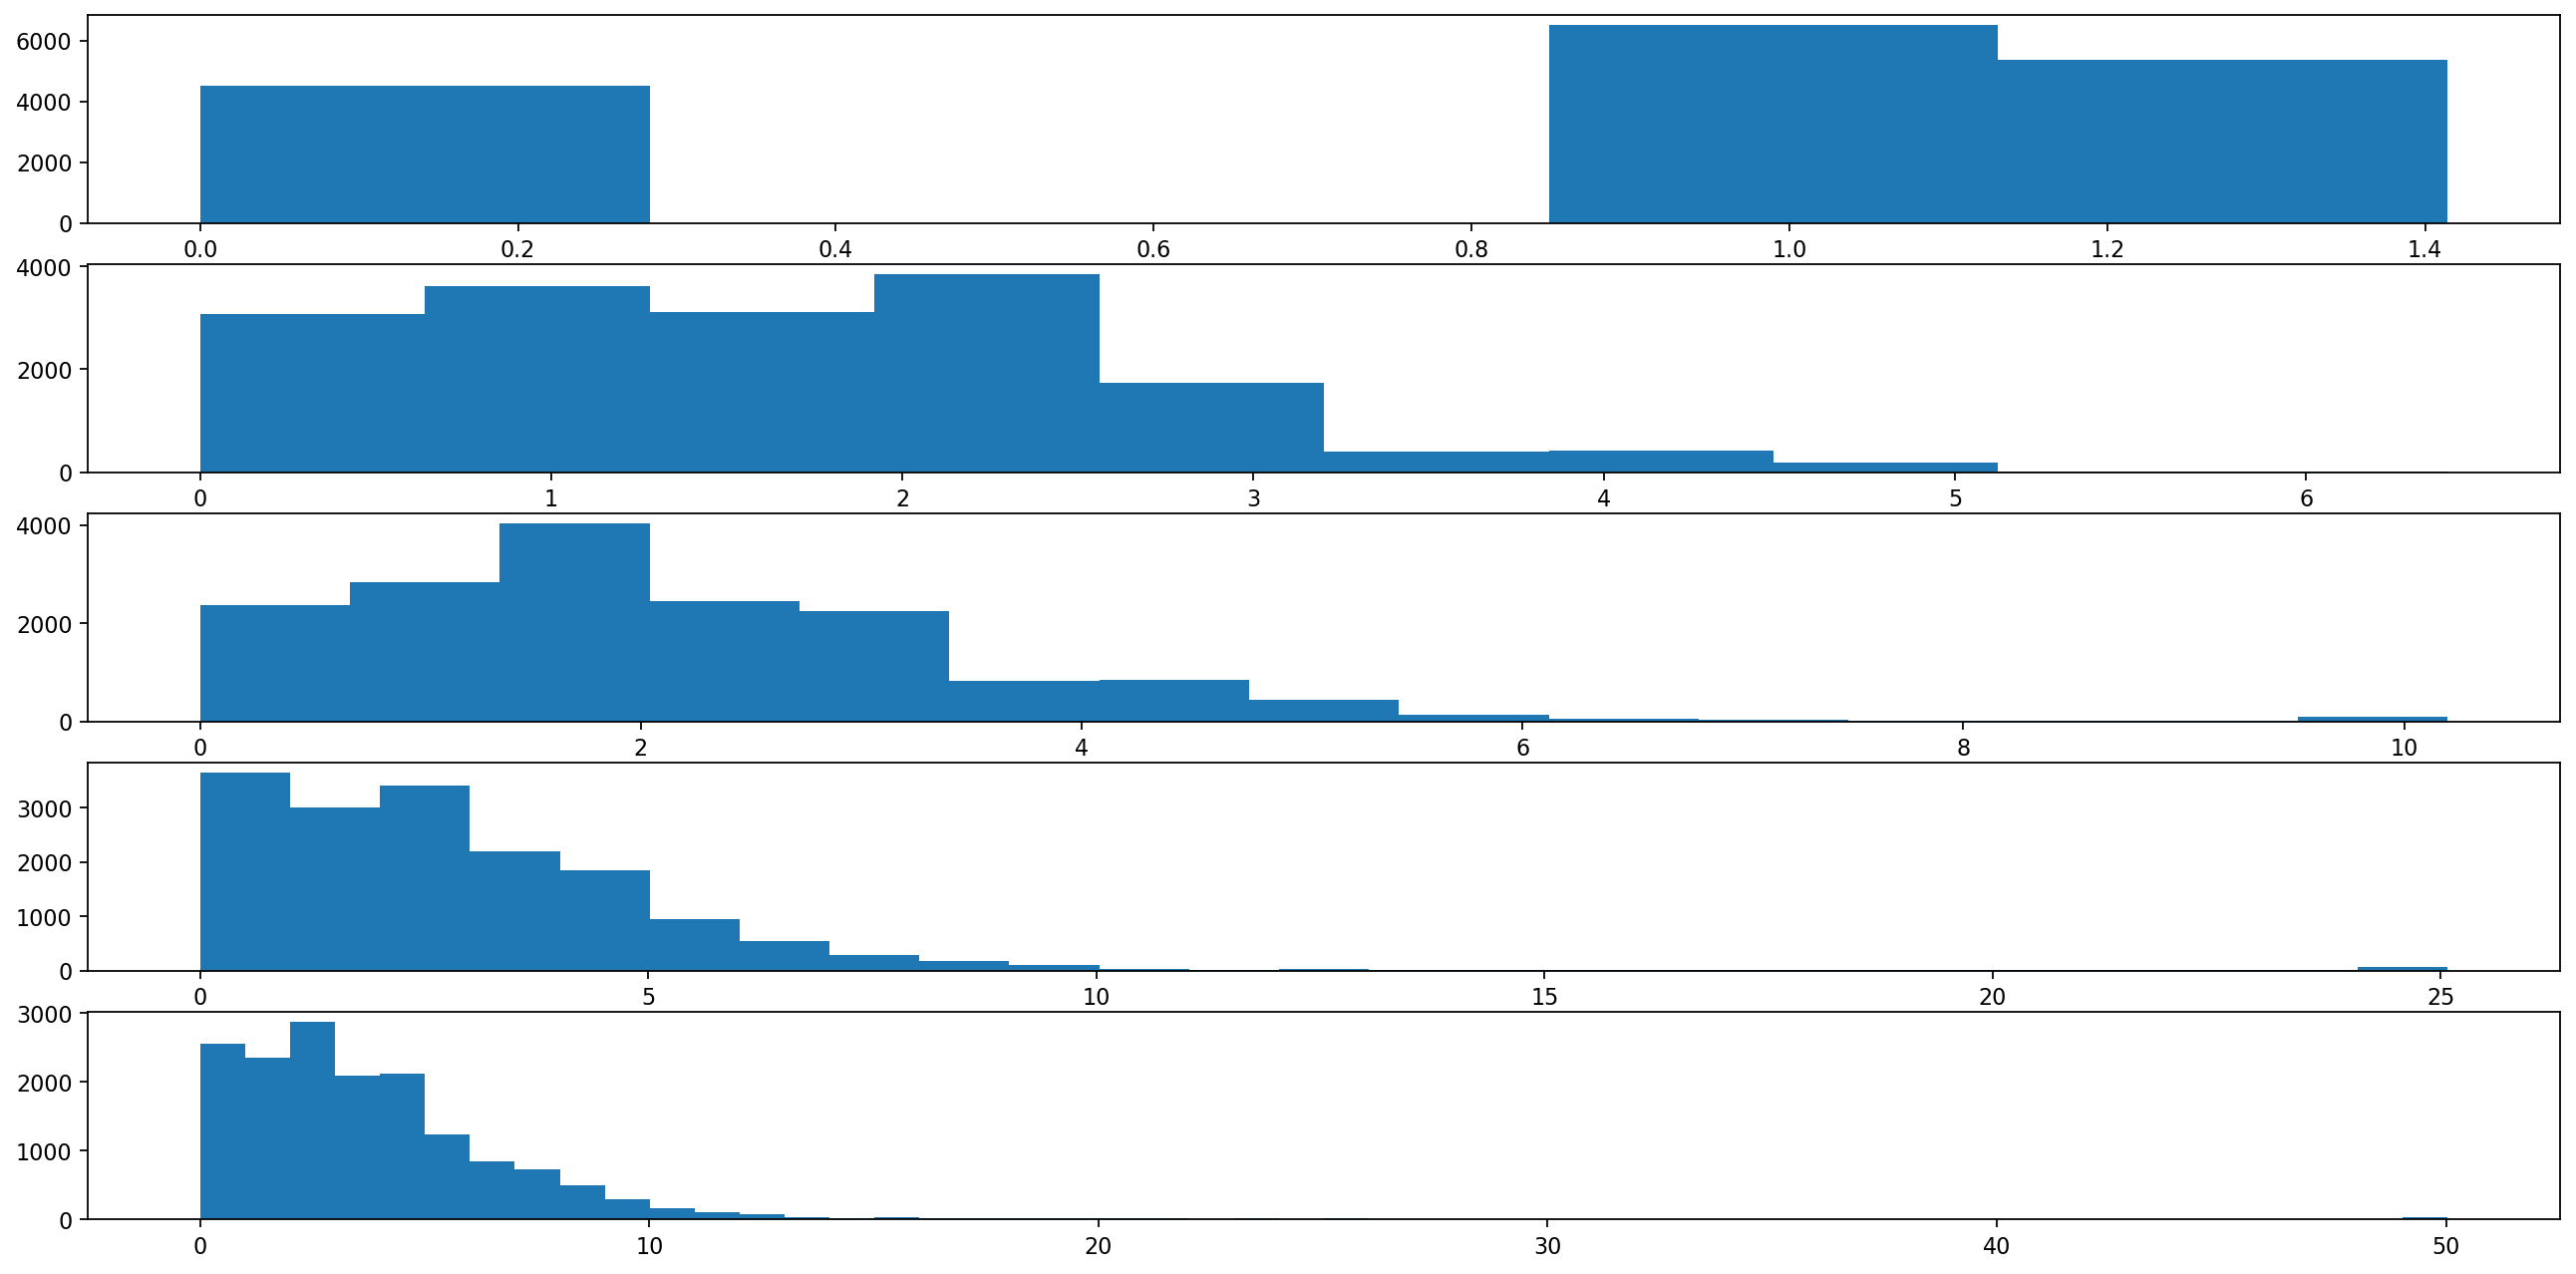

In [32]:
#fig, ax = plt.subplots(5)

for i in range(0, 5):
    print("Diffusion step {}".format((1, 5, 10, 25, 50)[i]))
    L_mean = np.mean(lengths[i])
    L_std = np.std(lengths[i])
    #print(lengths[i])
    print("Max: {:.3f}\tMin: {:.3f}".format(np.max(lengths[i]), np.min(lengths[i])))
    print("Mean: {:.3f}\STD: {:.3f}".format(np.mean(lengths[i]), np.std(lengths[i])))

    #ax[i].hist(lengths[i], bins=[5,10,15,25,50][i])

In [33]:
# convert lengths to nice for viewing csv
lcsv = np.zeros((len(lengths[i])+1, 5))
lcsv[0,:] = [1, 5, 10, 25, 50]
for i in range(5):
    lcsv[1:,i] = np.array(lengths[i]).T
print(lcsv)
np.savetxt('data/diffl80.txt', lcsv)

[[ 1.          5.         10.         25.         50.        ]
 [ 1.          5.         10.         25.         50.        ]
 [ 1.          5.         10.         25.         50.        ]
 ...
 [ 1.          3.16227766  1.41421356  1.41421356  3.16227766]
 [ 1.          4.47213595  1.          4.12310563  4.47213595]
 [ 1.          2.23606798  1.          3.16227766  1.        ]]


10
126


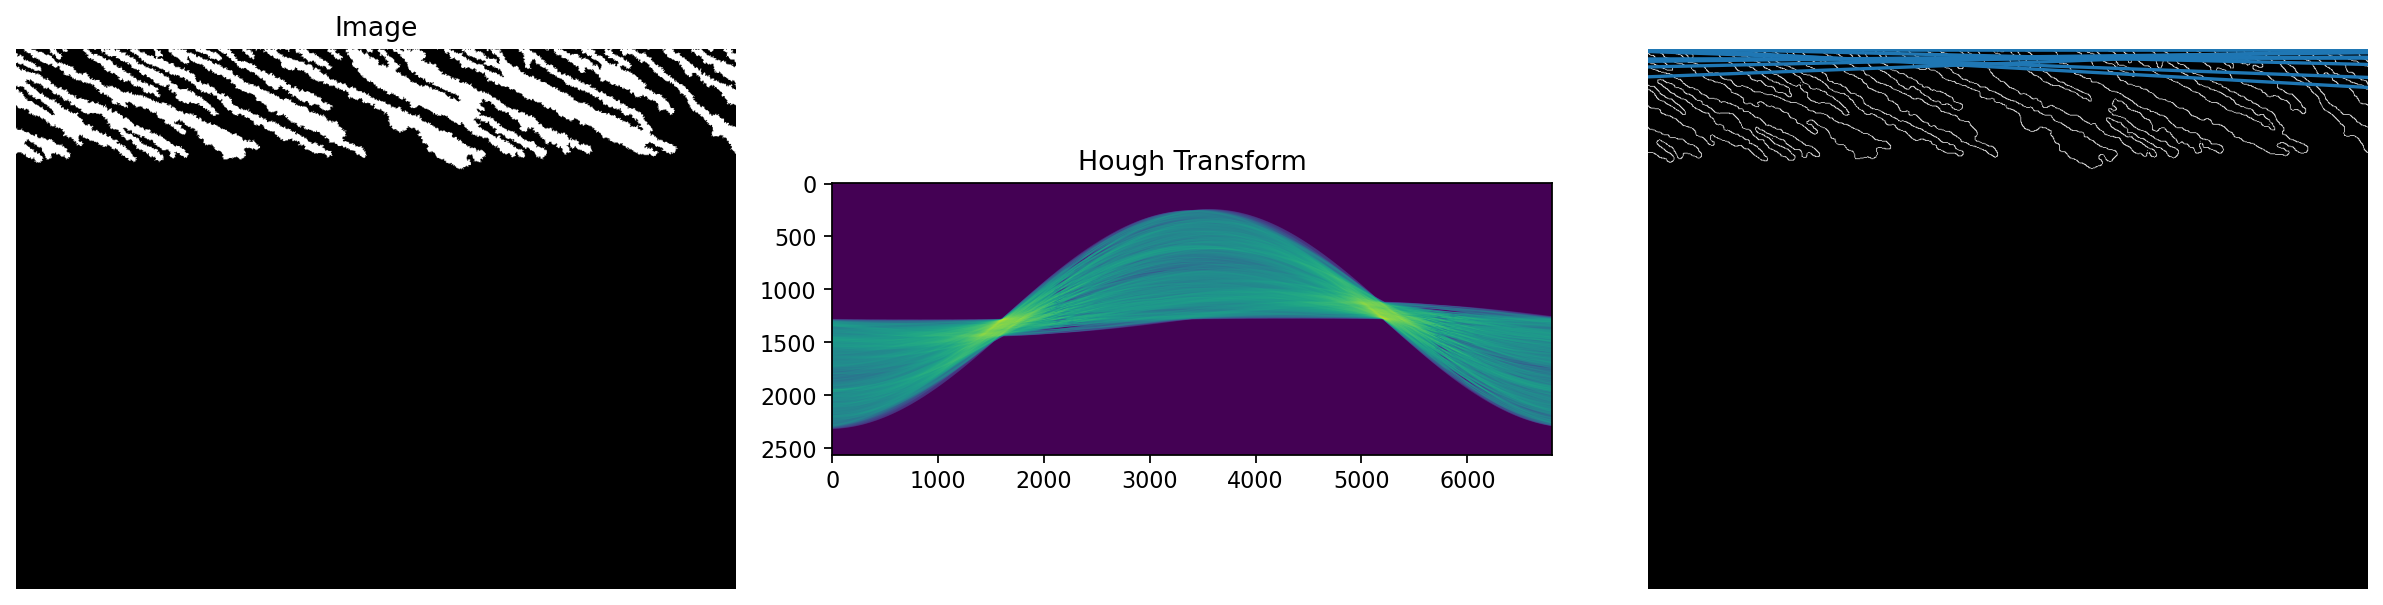

In [8]:
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.feature import canny
from skimage.draw import line
from scipy import ndimage


# load image and flip to 'nice' view
im, idep, ipar = loadGrid2D("diffusion//SCTF_Si_L1024_Th80_D25_N65536_1656478041.npy")
#im = grid
im = np.flip(im, axis=1).astype(np.uint8)*255

# tile image and fill
im2 = np.zeros((768, 1024*3))
for i in [0, 1, 2]:
    im2[:,1024*i:1024*(i+1)] = im
im2 = ndimage.binary_fill_holes(im2)

# get edges and crop
edges = canny(im2, sigma=2)#, low_threshold=10, high_threshold=50)
im = im2[:,1024:2048]
edges = edges[:,1024:2048]

# select angle range and get hough space
amin = 10
amax = 350
inangles = np.linspace(amin, amax, int((amax-amin)/.05))
h, t, d = hough_line(edges, theta=inangles/180*np.pi)

# get peaks
peaks = 10
accum, angles, dist = hough_line_peaks(h, t, d, num_peaks=peaks)
anglesd = angles/np.pi*180
print(len(angles))

# probabilistic Hough transform
lines = probabilistic_hough_line(edges, threshold=10, line_length=10, line_gap=3, theta=inangles/180*np.pi)
print(len(lines))

fig, axes = plt.subplots(1, 3, figsize=(15,6))
ax = axes.ravel()

ax[0].imshow(im, cmap='gray')
ax[0].set_title('Image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1+h))
ax[1].set_title('Hough Transform')

ax[2].imshow(edges, cmap='gray')
ax[2].set_ylim((im.shape[0], 0))
ax[2].set_xlim((0, im.shape[1]))
ax[2].set_axis_off()
#for line in lines:
#    p0, p1 = line
#    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
for _, angle, dist in zip(*hough_line_peaks(h, t, d, num_peaks=peaks)):
    (x0,y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))
#ax[2].hist(anglesd, bins=25)
#ax[2].imshow(edges, cmap='gray')
#ax[2].set_axis_off()


plt.tight_layout()
plt.show()

In [ ]:
print(anglesd)
low = []
high = []
for a in anglesd:
    if a < 180 and a > 91:
        low.append(a)
    elif a > 271 and a < 360:
        high.append(a)
low = np.array(low)-90
high = np.array(high)-90-180

print('Low:\n\tRange: {:.2f} to {:.2f}\n\tMean: {:.2f}'.format(np.min(low), np.max(low), np.mean(low)))
print('High:\n\tRange: {:.2f} to {:.2f}\n\tMean: {:.2f}'.format(np.min(high), np.max(high), np.mean(high)))

137


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  4.,  1., 22.,  2., 14., 13., 14.,
         9.,  4., 10., 20., 13.,  6.,  3.]),
 array([-24.77514057, -21.82203969, -18.86893881, -15.91583794,
        -12.96273706, -10.00963618,  -7.05653531,  -4.10343443,
         -1.15033355,   1.80276733,   4.7558682 ,   7.70896908,
         10.66206996,  13.61517084,  16.56827171,  19.52137259,
         22.47447347,  25.42757435,  28.38067522,  31.3337761 ,
         34.28687698]),
 <a list of 20 Patch objects>)

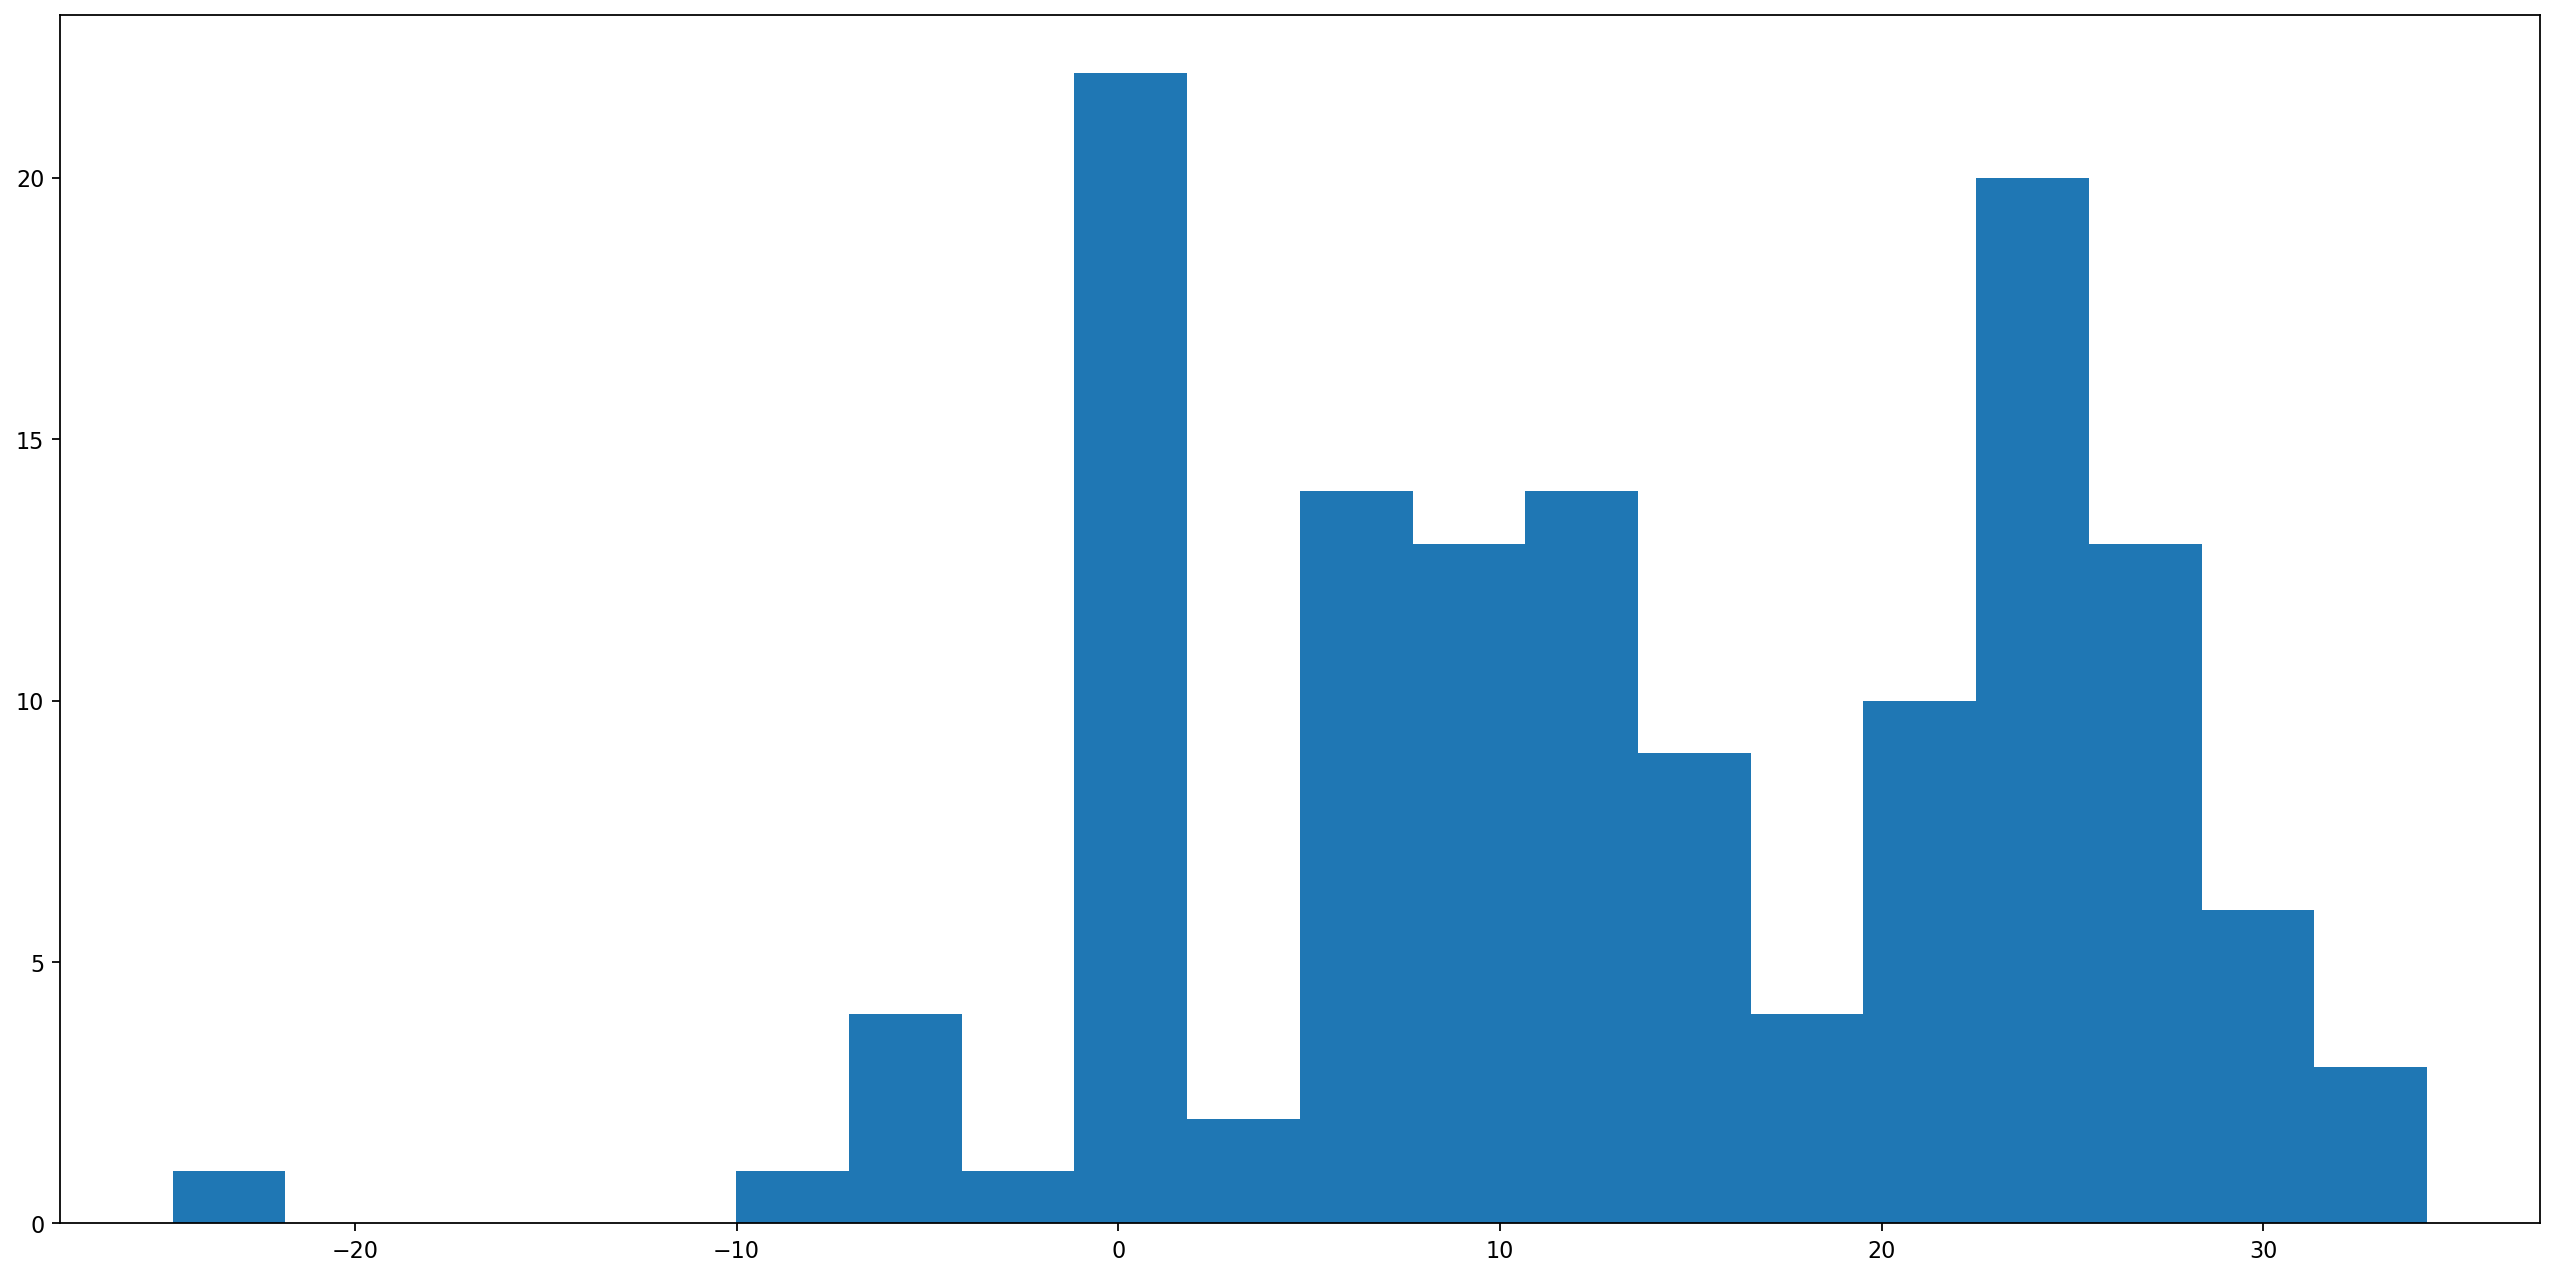

In [5]:
angle_segs = []
for line in lines:
    p0, p1 = line
    angle_segs.append(np.arctan((p1[1]-p0[1])/(p1[0]-p0[0])))
print(len(angle_segs))
angle_segs = np.array(angle_segs)*180/np.pi
fig, ax = plt.subplots()
ax.hist(angle_segs, bins=20)

In [ ]:
import os

results = []
for file in os.listdir('structures/2D/diffusion'):
    if not file.endswith('.npy'):
        continue
    im, idep, ipar = loadGrid2D('diffusion/' + file)
    print(ipar)
    im = np.flip(im, axis=1).astype(np.uint8)*255

    # tile image and fill
    im2 = np.zeros((768, 1024*3))
    for i in [0, 1, 2]:
        im2[:,1024*i:1024*(i+1)] = im
    im2 = ndimage.binary_fill_holes(im2)

    # get edges and crop
    edges = canny(im2, sigma=2)#, low_threshold=10, high_threshold=50)
    im = im2[:,1024:2048]
    edges = edges[:,1024:2048]

    # select angle range and get hough space
    amin = 5
    amax = 355
    inangles = np.linspace(amin, amax, int((amax-amin)/.05))
    h, t, d = hough_line(edges, theta=inangles/180*np.pi)

    # get peaks
    peaks = 50
    accum, angles, dist = hough_line_peaks(h, t, d, num_peaks=peaks)
    anglesd = angles/np.pi*180
        
    # locate peaks
    low = []
    high = []
    for a in anglesd:
        if a < 180 and a > 91:
            low.append(a)
        elif a > 271 and a < 360:
            high.append(a)
    low = np.array(low)-90
    high = np.array(high)-90-180
    
    results.append([ipar[0]['theta'], ipar[0]['D'], np.mean(low), np.mean(high)])
    
print(results)

## Analyze angles with FFT

503113 (491, 329)
(8398+0j)
24115846.324298155
-2.6249999999999836 1855.9999999999916
Closest angle is: -69.14554196042154
508
510
511
512
513
514
Low angle is: -70.710
High angle is: -60.945
(19, 2)
Minimum from many lines: -69.14420672409003


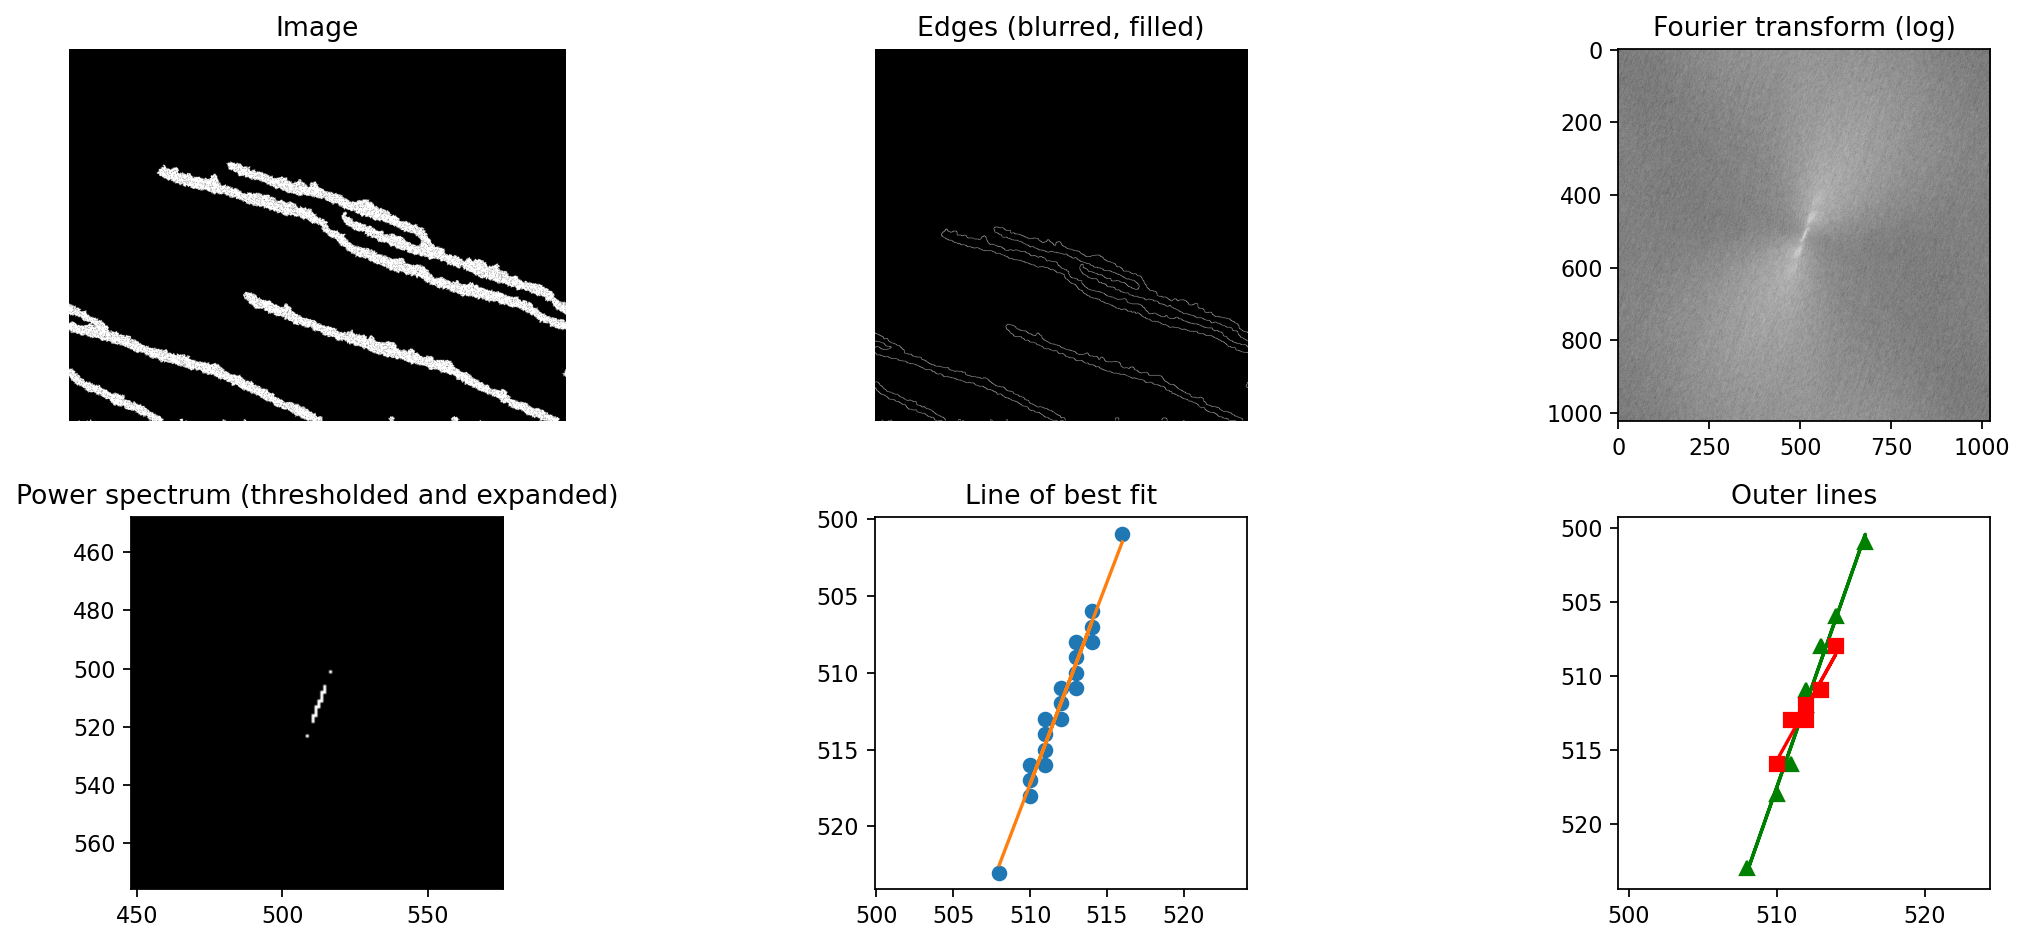

In [68]:
from skimage.feature import canny
from scipy import ndimage
from skimage.filters import gaussian

# load image and flip to 'nice' view
imin, idep, ipar = loadGrid2D("diffusion2//SCTF_Si_L1024_Th88_D100_N65536_1657176234.npy")
#im = grid
imin = gaussian(np.flip(imin, axis=0).astype(np.uint8)*255, sigma=0)

# tile image and fill
im2 = np.zeros((768, 1024*3))
for i in [0, 1, 2]:
    im2[:,1024*i:1024*(i+1)] = imin
im2 = ndimage.binary_fill_holes(im2)


# blur slightly
im2 = canny(im2, sigma=2)#, low_threshold=10, high_threshold=50)
im = im2[:,1024:2048]
im3 = np.pad(im, ((im.shape[1] - im.shape[0], 0), (0, 0)))

# get fft
f = (np.fft.fft2(im3))
f2 = (np.fft.fft2(im3))
print(np.argmax(im3), np.unravel_index(np.argmax(im3), im3.shape))
f = np.abs(np.fft.fftshift(f))
f2 = np.fft.fftshift(f2)
print(np.amax(f2))
print(np.amax(abs(f2[513:,:512])**2))
f2 = np.where(abs(f2)**2 < np.amax(abs(f2[f2.shape[1]//2+1:, :f2.shape[0]//2]))**2/4, 0, 255)


x = []
y = []
points = []
for i in range(f2.shape[0]):
    for j in range(f2.shape[1]):
        if f2[i,j] > 0:
            x.append(j)
            y.append(i)
            points.append((j,i))
            
x = np.array(x)
y = np.array(y)
xstack = np.vstack([x, np.ones(len(x))]).T
m1, c1 = np.linalg.lstsq(xstack, y, rcond=None)[0]
print(m1, c1)
print('Closest angle is: {}'.format(np.arctan(m1)*180/np.pi))

# low and high slopes
xlow = []
ylow = []
xhigh = []
yhigh = []
plow = np.argmax(f2, axis=0)
phigh = np.argmax(np.flip(f2, axis=0), axis=0)
phigh = np.where(phigh != 0, f2.shape[0]-phigh-1, 0)
for i in range(plow.shape[0]):
    if plow[i] != 0 and plow[i] < m1*i+c1:
        if i < plow.shape[0]//2:
            xhigh.append(i)
            yhigh.append(plow[i])
        else:
            xlow.append(i)
            ylow.append(plow[i])
for i in range(phigh.shape[0]):
    if phigh[i] != 0 and phigh[i] > m1*i+c1:
        print(i)
        if i < phigh.shape[0]//2:
            xlow.append(i)
            ylow.append(phigh[i])
        else:
            xhigh.append(i)
            yhigh.append(phigh[i])
xlow.append(f2.shape[1]//2)
ylow.append(f2.shape[0]//2)
xhigh.append(f2.shape[1]//2)
yhigh.append(f2.shape[0]//2)
xlow = np.array(xlow)
ylow = np.array(ylow)
xhigh = np.array(xhigh)
yhigh = np.array(yhigh)
xlstack = np.vstack([xlow, np.ones(len(xlow))]).T
xhstack = np.vstack([xhigh, np.ones(len(xhigh))]).T
mlow, clow = np.linalg.lstsq(xlstack, ylow, rcond=None)[0]
mhigh, chigh = np.linalg.lstsq(xhstack, yhigh, rcond=None)[0]
print('Low angle is: {:.3f}\nHigh angle is: {:.3f}'.format(np.arctan(mlow)*180/np.pi, np.arctan(mhigh)*180/np.pi))
#print('Shape of all points: {}\nShape of low points: {}\nShape of high points: {}'.format(len(y), len(ylow), len(yhigh)))

#f[-50:50,-50:50] = 0
#f2 [-20:20,-20:20] = 0

#f = np.fft.fftshift(f)

''' Next: iterate over lines of each angle and calculate error; plot the error vs angle and it should give good boundaries '''
anglerange = np.linspace(-90, 90, 3600)
S = np.zeros(anglerange.shape)
points = np.stack([x, y], axis=1)
print(points.shape)
xc = f2.shape[0]//2
yc = f2.shape[1]//2
for i in range(len(anglerange)):
    m = np.tan(anglerange[i]*np.pi/180)
    for j in range(points.shape[0]):
        p = points[j,:]
        # S = sum (yi - m*x)
        if anglerange[i] != 180:
            S[i] += (p[1] - yc - m*(p[0] - xc))**2
        else:
            S[i] = np.inf
min_error = np.argmin(S)
min_angle = anglerange[min_error]
mmin = np.tan(min_angle/180*np.pi)
print("Minimum from many lines: {}".format(min_angle))

residuals = np.zeros(len(points))
for i in range(points.shape[0]):
    p = points[i,:]
    # S = sum (yi - m*x)
    #if (p[0]-xc)**2 + (p[1]-yc)**2 < 10000:
    residuals[i] = (p[1] - yc - mmin*(p[0] - xc))**2
    #else:
        #residuals[i] = 0
#residuals = np.where[not np.isnan(residuals)]
        

#lowmax = np.unravel_index(np.argmax(f2[:im.shape[0]//2-1, :im.shape[1]//2-1]), im.shape)
#highmax = np.unravel_index(np.argmax(f2[im.shape[0]//2+1:, im.shape[1]//2+1:]), im.shape)
#print(lowmax, highmax)


#plot
fig, ax = plt.subplots(2, 3, figsize=(15,6))
#ax = axes.ravel()

ax[0,0].imshow(imin, cmap='gray')
ax[0,0].set_title('Image')
ax[0,0].set_axis_off()

ax[0,1].imshow(im3, cmap='gray')
ax[0,1].set_title('Edges (blurred, filled)')
ax[0,1].set_axis_off()

ax[0,2].imshow(np.log(abs(f)), cmap='gray')
ax[0,2].set_title('Fourier transform (log)')
#ax[0,1].set_axis_off()

ax[1,0].imshow(f2.real[f2.shape[0]*7//16:f2.shape[0]*9//16, f2.shape[1]*7//16:f2.shape[1]*9//16], cmap='gray', extent=[f2.shape[0]*7//16, f2.shape[0]*9//16, f2.shape[1]*9//16, f2.shape[1]*7//16])
ax[1,0].set_title('Power spectrum (thresholded and expanded)')
#ax[0,2].set_axis_off()

#ax[0,2].plot(x, y, 'o')
#ax[0,2].plot(x, m1*x+c1)
#ax[0,2].set_title('Line of best fit')
#ax[2].imshow(edges, cmap='gray')
#ax[2].set_axis_off()

ax[1,1].plot(x, y, 'o')
ax[1,1].plot(x, mmin*(x-xc)+yc)
ax[1,1].set_title('Line of best fit')
ax[1,1].set_xlim(ax[1,1].get_ylim())
ax[1,1].invert_yaxis()
ax[1,1].set_aspect('equal')

ax[1,2].plot(xlow, ylow, 'g^')
ax[1,2].plot(xlow, xlow*mlow+clow, 'g')
ax[1,2].plot(xhigh, yhigh, 'rs')
ax[1,2].plot(xhigh, xhigh*mhigh+chigh, 'r')
ax[1,2].set_title('Outer lines')
ax[1,2].set_xlim(ax[1,2].get_ylim())
ax[1,2].invert_yaxis()
ax[1,2].set_aspect('equal')

#ax[1,2].plot(anglerange[min_error-200:min_error+200], (S[min_error-200:min_error+200]))
#ax[1,2].set_xlim([min_angle-15, min_angle+15])
#ax[1,2].autoscale()
#ax[1,2].set_title('Squared error')
ax[1,2].set_aspect('equal')

#ax[1,2].plot(residuals, 'ro')
#ax[1,2].set_title('residuals')

plt.tight_layout()
plt.show()

In [ ]:
print("Uncertainty: {}".format(np.sum(residuals)/(np.count_nonzero(residuals)-1)))

In [137]:
from skimage.filters import gaussian
import os

results = []
for file in os.listdir('structures/2D/diffusion'):
    if not file.endswith('.npy'):
        continue
    # load image and flip to 'nice' view
    im, idep, ipar = loadGrid2D('diffusion/' + file)
    im = gaussian(np.flip(im, axis=0).astype(np.uint8)*255, sigma=0)

    # tile image and fill
    im2 = np.zeros((768, 1024*3))
    for i in [0, 1, 2]:
        im2[:,1024*i:1024*(i+1)] = im
    im2 = ndimage.binary_fill_holes(im2)

    # blur slightly
    im2 = canny(im2, sigma=2)#, low_threshold=10, high_threshold=50)
    im = im2[:,1024:2048]
    im3 = np.pad(im, ((im.shape[1] - im.shape[0], 0), (0, 0)))

    # get fft
    f = (np.fft.fft2(im)).real
    f2 = (np.fft.fft2(im3)).real
    #print(np.argmax(im3), np.unravel_index(np.argmax(im3), im3.shape))
    f2 = np.fft.fftshift(f2)
    f2 = np.where(f2 < 700, 0, 255)

    x = []
    y = []
    points = []
    for i in range(f2.shape[0]):
        for j in range(f2.shape[1]):
            if f2[i,j] > 0:
                x.append(i)
                y.append(j)
                points.append((i,j))

    x = np.array(x)
    y = np.array(y)

    xstack = np.vstack([x, np.ones(len(x))]).T

    m1, c1 = np.linalg.lstsq(xstack, y, rcond=None)[0]
    #print(m1, c1)
    #print('Closest angle is: {}'.format(np.arctan(m1)*180/np.pi))

    #f[-50:50,-50:50] = 0
    #f2 [-20:20,-20:20] = 0

    #f = np.fft.fftshift(f)

    ''' Next: iterate over lines of each angle and calculate error; plot the error vs angle and it should give good boundaries '''
    anglerange = np.linspace(-90, 90, 3600)
    S = np.zeros(anglerange.shape)
    points = np.stack([x, y], axis=1)
    #print(points.shape)
    xc = f2.shape[0]//2
    yc = f2.shape[1]//2
    for i in range(len(anglerange)):
        m = np.tan(anglerange[i]*np.pi/180)
        for j in range(points.shape[0]):
            p = points[j,:]
            # S = sum (yi - m*x)
            if anglerange[i] != 180:
                S[i] += (p[1] - yc - m*(p[0] - xc))**2
            else:
                S[i] = np.inf
    min_error = np.argmin(S)
    min_angle = anglerange[min_error]
    mmin = np.tan(min_angle/180*np.pi)
    #print("Minimum from many lines: {}".format(min_angle))

    '''residuals = np.zeros(len(points))
    for i in range(points.shape[0]):
        p = points[i,:]
        # S = sum (yi - m*x)
        if (p[0]-xc)**2 + (p[1]-yc)**2 < 10000:
            residuals[i] = (p[1] - yc - mmin*(p[0] - xc))**2
        else:
            residuals[i] = 0'''
    print(ipar[0]['theta'], ipar[0]['D'])
    results.append([ipar[0]['theta'], ipar[0]['D'], np.arctan(m1)*180/np.pi, min_angle])
    
print(results)

80 0
80 100
80 10
80 1
80 25
80 50
80 5
80 75
84 0
84 100
84 10
84 1
84 25
84 50
84 5
84 75
85.5 0
85.5 100
85.5 10
85.5 1
85.5 25
85.5 50
85.5 5
85.5 75
86 0
86 100
86 10
86 1
86 25
86 50
86 5
86 75
88 0
88 100
88 10
88 1
88 25
88 50
88 5
88 75
[[80, 0, -21.950367320663684, -21.93109196999167], [80, 100, -28.751202586748605, -28.7329813837177], [80, 10, -27.97338373863688, -27.982772992497914], [80, 1, -25.045288451820806, -25.031953320366767], [80, 25, -27.516914346508063, -27.532647957766045], [80, 50, -29.52349318879764, -29.53320366768547], [80, 5, -28.239511749864626, -28.23284245623784], [80, 75, -29.18502836186344, -29.18310641844957], [84, 0, -17.186610568005566, -17.179772158933034], [84, 100, -26.280127664512477, -26.282300639066406], [84, 10, -24.53847021983432, -24.531814392886915], [84, 1, -20.70549629407952, -20.68074465129203], [84, 25, -24.717766232131062, -24.73186996387885], [84, 50, -26.877081772882846, -26.882467352042234], [84, 5, -23.506167488960045, -23.48152264

In [161]:
import os

results = []
for file in os.listdir('structures/2D/diffusion'):
    if not file.endswith('.npy'):
        continue
    # load image and flip to 'nice' view
    im, idep, ipar = loadGrid2D('diffusion/' + file)
    im = gaussian(np.flip(im, axis=0).astype(np.uint8)*255, sigma=0)

    # tile image and fill
    im2 = np.zeros((768, 1024*3))
    for i in [0, 1, 2]:
        im2[:,1024*i:1024*(i+1)] = im
    im2 = ndimage.binary_fill_holes(im2)
    im2 = im2[:,1024:2048]
    
    # get densities
    for i in range(im.shape[0]):
        if np.sum(im[im.shape[0] - i - 1,:]) > 0:
            maxh = i + 1
        else:
            break
    #maxh = np.max(np.argmax(im, axis=0))
    print(maxh)
    density_porous = np.count_nonzero(im) / (maxh * im.shape[1])
    density_filled = np.count_nonzero(im2) / (maxh * im2.shape[1])
    
    print(ipar[0]['theta'], ipar[0]['D'])
    results.append([ipar[0]['theta'], ipar[0]['D'], density_porous, density_filled])
    
print(results)

184
80 0
158
80 100
187
80 10
212
80 1
171
80 25
160
80 50
185
80 5
154
80 75
227
84 0
221
84 100
253
84 10
288
84 1
244
84 25
230
84 50
270
84 5
231
84 75
239
85.5 0
271
85.5 100
325
85.5 10
340
85.5 1
297
85.5 25
302
85.5 50
334
85.5 5
273
85.5 75
257
86 0
305
86 100
338
86 10
373
86 1
326
86 25
334
86 50
361
86 5
323
86 75
335
88 0
516
88 100
579
88 10
665
88 1
569
88 25
548
88 50
623
88 5
510
88 75
[[80, 0, 0.34782608695652173, 0.472098972486413], [80, 100, 0.4050632911392405, 0.42978021162974683], [80, 10, 0.3422459893048128, 0.39357035427807485], [80, 1, 0.3018867924528302, 0.4026063163325472], [80, 25, 0.3742690058479532, 0.41581003289473684], [80, 50, 0.4, 0.432232666015625], [80, 5, 0.34594594594594597, 0.41738809121621623], [80, 75, 0.4155844155844156, 0.45313768262987014], [84, 0, 0.28193832599118945, 0.37030217511013214], [84, 100, 0.2895927601809955, 0.3075155542986425], [84, 10, 0.25296442687747034, 0.3175603693181818], [84, 1, 0.2222222222222222, 0.2878926595052083], [84

In [162]:
for l in results:
    print("{},{},{},{}".format(l[0], l[1], l[2], l[3]))

angd = {'80': 1, '84': 2, '85.5': 3, '86': 4, '85': 5}
difd = {'0': 1, '1': 2, '5': 3, '10': 4, '25': 5, '50': 6, '75': 7, '100': 8}

tab = 0

80,0,0.34782608695652173,0.472098972486413
80,100,0.4050632911392405,0.42978021162974683
80,10,0.3422459893048128,0.39357035427807485
80,1,0.3018867924528302,0.4026063163325472
80,25,0.3742690058479532,0.41581003289473684
80,50,0.4,0.432232666015625
80,5,0.34594594594594597,0.41738809121621623
80,75,0.4155844155844156,0.45313768262987014
84,0,0.28193832599118945,0.37030217511013214
84,100,0.2895927601809955,0.3075155542986425
84,10,0.25296442687747034,0.3175603693181818
84,1,0.2222222222222222,0.2878926595052083
84,25,0.26229508196721313,0.2942614946209016
84,50,0.2782608695652174,0.29557999320652173
84,5,0.23703703703703705,0.3079029224537037
84,75,0.27705627705627706,0.30560064935064934
85.5,0,0.26778242677824265,0.35574660041841005
85.5,100,0.23616236162361623,0.2516396160055351
85.5,10,0.19692307692307692,0.23356370192307693
85.5,1,0.18823529411764706,0.24360638786764705
85.5,25,0.21548821548821548,0.2417238794191919
85.5,50,0.2119205298013245,0.24505898178807947
85.5,5,0.191616766

In [ ]:
for l in results:
    print("{},{},{:.2f},{:.2f}".format(l[0], l[1], l[2], l[3]))

In [ ]:
#print(surface.energy[1], np.max(grid))
showImage(np.flip(surface.pointgrid[:,:,0], axis=0).astype(np.uint8))

In [ ]:
saveGrid2D(grid.astype(np.uint8), deposited, params, system)

In [ ]:
mu, sigma = 0, 1.366 # mean and standard deviation
distribution = np.random.default_rng().normal(mu, sigma, 10000)

In [ ]:
print(grid)
plt.subplot(111)
im = plt.imshow(surface.energy[1], cmap="viridis", vmax=np.max(surface.energy[1]), vmin=0)
plt.colorbar(im)
plt.show()